# Intro
### This project focuses on visualization, analysis, cleaning, preprocessing raw New York City real estate sales data. 

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import regex as re

from scipy.stats import iqr
from scipy.stats import zscore
from scipy.stats import skew

import matplotlib.image as mpimg
from PIL import Image

from sklearn import preprocessing

from sklearn.ensemble import IsolationForest

from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.metrics import mean_squared_error

# download data

In [83]:
nyc_data = pd.read_csv('nyc-rolling-sales.csv')
nyc_data.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [84]:
# Unnamed: 0 looks like a form of index, so we don't need it
nyc_data.drop(['Unnamed: 0'], axis  =1, inplace = True)

In [85]:
nyc_data.dtypes

BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

# cleaning

In [86]:
nyc_data.info()
print(' \nWE CAN SEE THAT SOME NUMERIC COLUMNS ARE OBJECTS TYPE INSTEAD OF STRINGS AND \n\
 SOME CATEGORICAL COLUMNS ARE OBJECTS OR INTS')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING CLASS AT PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT NUMBER                84548 non-null  object
 10  ZIP CODE                        84548 non-null  int64 
 11  RESIDENTIAL UNITS               84548 non-null  int64 
 12  COMMERCIAL UNITS                84548 non-null

In [87]:
print(nyc_data.isna().sum())
print(' \nThere are no Nan values, which is a bit strange. This means that Nan values are\n\
hidden as zeros, or other symbols indicating a missing value')

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
EASE-MENT                         0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
APARTMENT NUMBER                  0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64
 
There are no Nan values, which is a bit strange. This means that Nan values are
hidden as zeros, or other symbols indicating a missing value


In [88]:
nyc_data.drop_duplicates(keep = False, inplace = True)
nyc_data.duplicated().sum()

0

### categorical data

In [89]:
nyc_data.select_dtypes(include = 'object').head()

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,LAND SQUARE FEET,GROSS SQUARE FEET,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,,C2,153 AVENUE B,,1633,6440,C2,6625000,2017-07-19 00:00:00
1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,,C7,234 EAST 4TH STREET,,4616,18690,C7,-,2016-12-14 00:00:00
2,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,,C7,197 EAST 3RD STREET,,2212,7803,C7,-,2016-12-09 00:00:00
3,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,,C4,154 EAST 7TH STREET,,2272,6794,C4,3936272,2016-09-23 00:00:00
4,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,,C2,301 EAST 10TH STREET,,2369,4615,C2,8000000,2016-11-17 00:00:00


In [90]:
print('unique values in EASE_MENT column:   {}'.format(np.unique(nyc_data['EASE-MENT'])))
apartment_number_empty_rate = nyc_data['APARTMENT NUMBER'].value_counts()[0]/nyc_data.shape[0]
apartment_number_empty_rate = np.round(apartment_number_empty_rate, 2) * 100 
print('percent of empty values in APARTMENT NUMBER:    {}%'.format(apartment_number_empty_rate))

unique values in EASE_MENT column:   [' ']
percent of empty values in APARTMENT NUMBER:    78.0%


In [91]:
# we will drop EASE-MENT and APARTMENT NUMBER, SALE DATE and ADDRESS, NEIGHBORHOOD (since we have zip-code and borough)
nyc_data.drop(['APARTMENT NUMBER', 'EASE-MENT', 'ADDRESS', 'SALE DATE', 'NEIGHBORHOOD'], axis = 1, inplace = True)

In [92]:
print(nyc_data.select_dtypes(include = 'object').info())
print(' \nColumns LAND SQUARE FEET, GROSS SQUARE FEET, SALE PRICE should be numerical not categorical')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83102 entries, 0 to 84547
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BUILDING CLASS CATEGORY         83102 non-null  object
 1   TAX CLASS AT PRESENT            83102 non-null  object
 2   BUILDING CLASS AT PRESENT       83102 non-null  object
 3   LAND SQUARE FEET                83102 non-null  object
 4   GROSS SQUARE FEET               83102 non-null  object
 5   BUILDING CLASS AT TIME OF SALE  83102 non-null  object
 6   SALE PRICE                      83102 non-null  object
dtypes: object(7)
memory usage: 5.1+ MB
None
 
Columns LAND SQUARE FEET, GROSS SQUARE FEET, SALE PRICE should be numerical not categorical


In [93]:
nyc_data['LAND SQUARE FEET'] = pd.to_numeric(nyc_data['LAND SQUARE FEET'], errors = 'coerce', downcast = 'integer')
nyc_data['GROSS SQUARE FEET'] = pd.to_numeric(nyc_data['GROSS SQUARE FEET'], errors = 'coerce', downcast = 'integer')
nyc_data['SALE PRICE'] = pd.to_numeric(nyc_data['SALE PRICE'], errors = 'coerce', downcast = 'integer')

nyc_data['TAX CLASS AT TIME OF SALE'] = nyc_data['TAX CLASS AT TIME OF SALE'].astype(dtype = 'category')
nyc_data['BOROUGH'] = nyc_data['BOROUGH'].astype(dtype = 'category')

In [94]:
# converting remaining zeros to Nan
nyc_data['LAND SQUARE FEET'].replace(0, np.nan, inplace = True)
nyc_data['GROSS SQUARE FEET'].replace(0, np.nan, inplace = True)
nyc_data['SALE PRICE'].replace(0, np.nan, inplace = True)

In [95]:
nyc_data.drop_duplicates(keep = False, inplace = True)
nyc_data.duplicated().sum()

0

### numerical 

In [96]:
nyc_data.select_dtypes(exclude = 'object').head()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
0,1,392,6,10009,5,0,5,1633.0,6440.0,1900,2,6625000.0
1,1,399,26,10009,28,3,31,4616.0,18690.0,1900,2,NaN
2,1,399,39,10009,16,1,17,2212.0,7803.0,1900,2,NaN
3,1,402,21,10009,10,0,10,2272.0,6794.0,1913,2,3936272.0
4,1,404,55,10009,6,0,6,2369.0,4615.0,1900,2,8000000.0


In [97]:
nyc_data.select_dtypes(exclude = 'object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79457 entries, 0 to 84547
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   BOROUGH                    79457 non-null  category
 1   BLOCK                      79457 non-null  int64   
 2   LOT                        79457 non-null  int64   
 3   ZIP CODE                   79457 non-null  int64   
 4   RESIDENTIAL UNITS          79457 non-null  int64   
 5   COMMERCIAL UNITS           79457 non-null  int64   
 6   TOTAL UNITS                79457 non-null  int64   
 7   LAND SQUARE FEET           45752 non-null  float64 
 8   GROSS SQUARE FEET          43521 non-null  float64 
 9   YEAR BUILT                 79457 non-null  int64   
 10  TAX CLASS AT TIME OF SALE  79457 non-null  category
 11  SALE PRICE                 58142 non-null  float64 
dtypes: category(2), float64(3), int64(7)
memory usage: 6.8 MB


In [98]:
nyc_data.select_dtypes(exclude = 'object').describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,79457.000000,79457.000000,79457.000000,79457.000000,79457.000000,79457.000000,4.575200e+04,4.352100e+04,79457.000000,5.814200e+04
mean,4247.750809,384.201480,10728.161496,1.999245,0.178474,2.207169,4.650888e+03,4.776256e+03,1788.015140,1.520467e+06
std,3572.881005,664.823113,1303.492114,16.090237,8.621511,18.384453,4.628054e+04,3.911241e+04,539.359919,1.248583e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00,8.000000e+01,0.000000,1.000000e+00
25%,1327.000000,22.000000,10305.000000,0.000000,0.000000,1.000000,2.000000e+03,1.408000e+03,1920.000000,3.800000e+05
50%,3328.000000,51.000000,11209.000000,1.000000,0.000000,1.000000,2.500000e+03,1.980000e+03,1939.000000,6.364060e+05
75%,6257.000000,1002.000000,11357.000000,2.000000,0.000000,2.000000,4.000000e+03,2.850000e+03,1966.000000,1.099710e+06
max,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


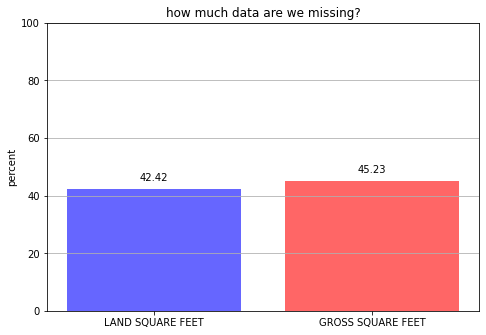

In [99]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
rows = nyc_data.shape[0]

columns = ['LAND SQUARE FEET', 'GROSS SQUARE FEET']
percent = [np.round(nyc_data['LAND SQUARE FEET'].isna().sum()/rows*100, 2), 
           np.round(nyc_data['GROSS SQUARE FEET'].isna().sum()/rows*100, 2)]

ax.bar(columns, percent, color = ['b', 'r'], alpha = 0.6)
ax.set_ylim(0, 100)
plt.title('how much data are we missing?')
plt.ylabel('percent')
plt.grid(axis = 'y')

rects = ax.patches
for rect, label in zip(rects, percent):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 2, label, ha = 'center', va = 'bottom')
    
plt.show()    

#### let's look into building and tax categories to decide whether we should impute GROSS SQUARE FEET and LAND SQUARE FEET

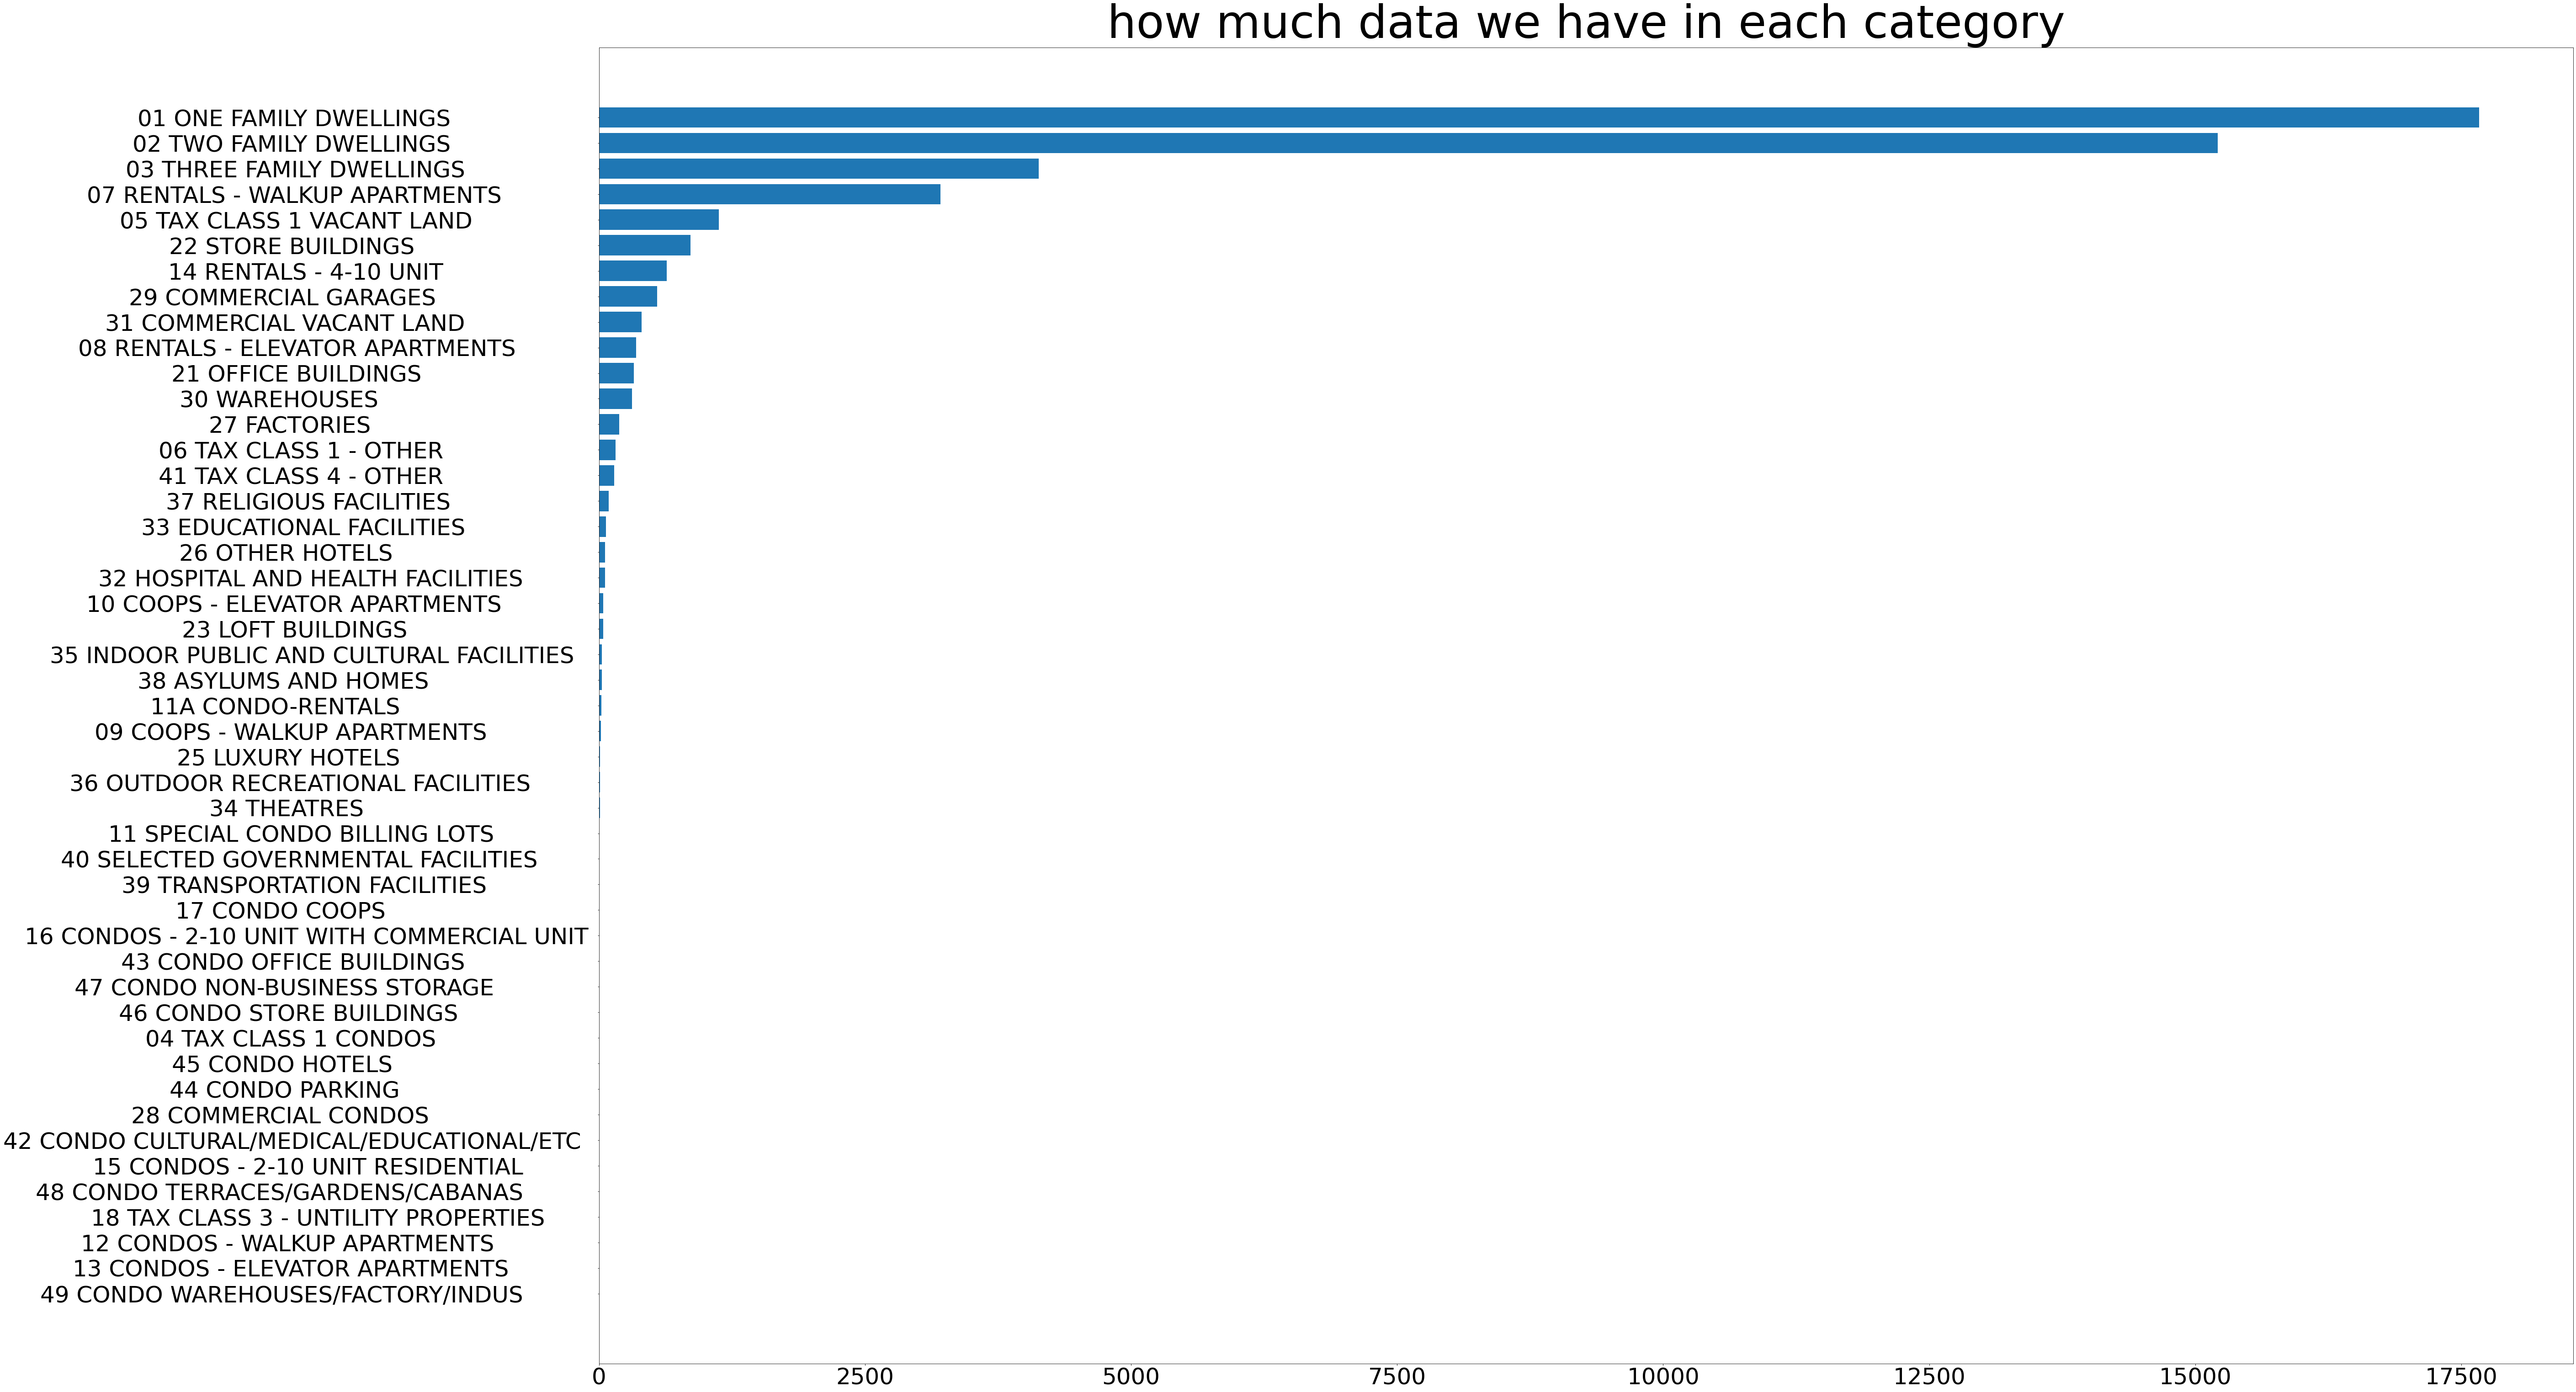

In [100]:
fig = plt.figure()
ax = fig.add_axes([1,1,10,10])

data = nyc_data['LAND SQUARE FEET'].groupby(nyc_data['BUILDING CLASS CATEGORY']).count()
data = data.sort_values(ascending = True)

categories = data.index
values = data.values

ax.tick_params(axis = 'both', labelsize = 50)
ax.barh(categories, values)

ax.set_title('how much data we have in each category', size = 100);

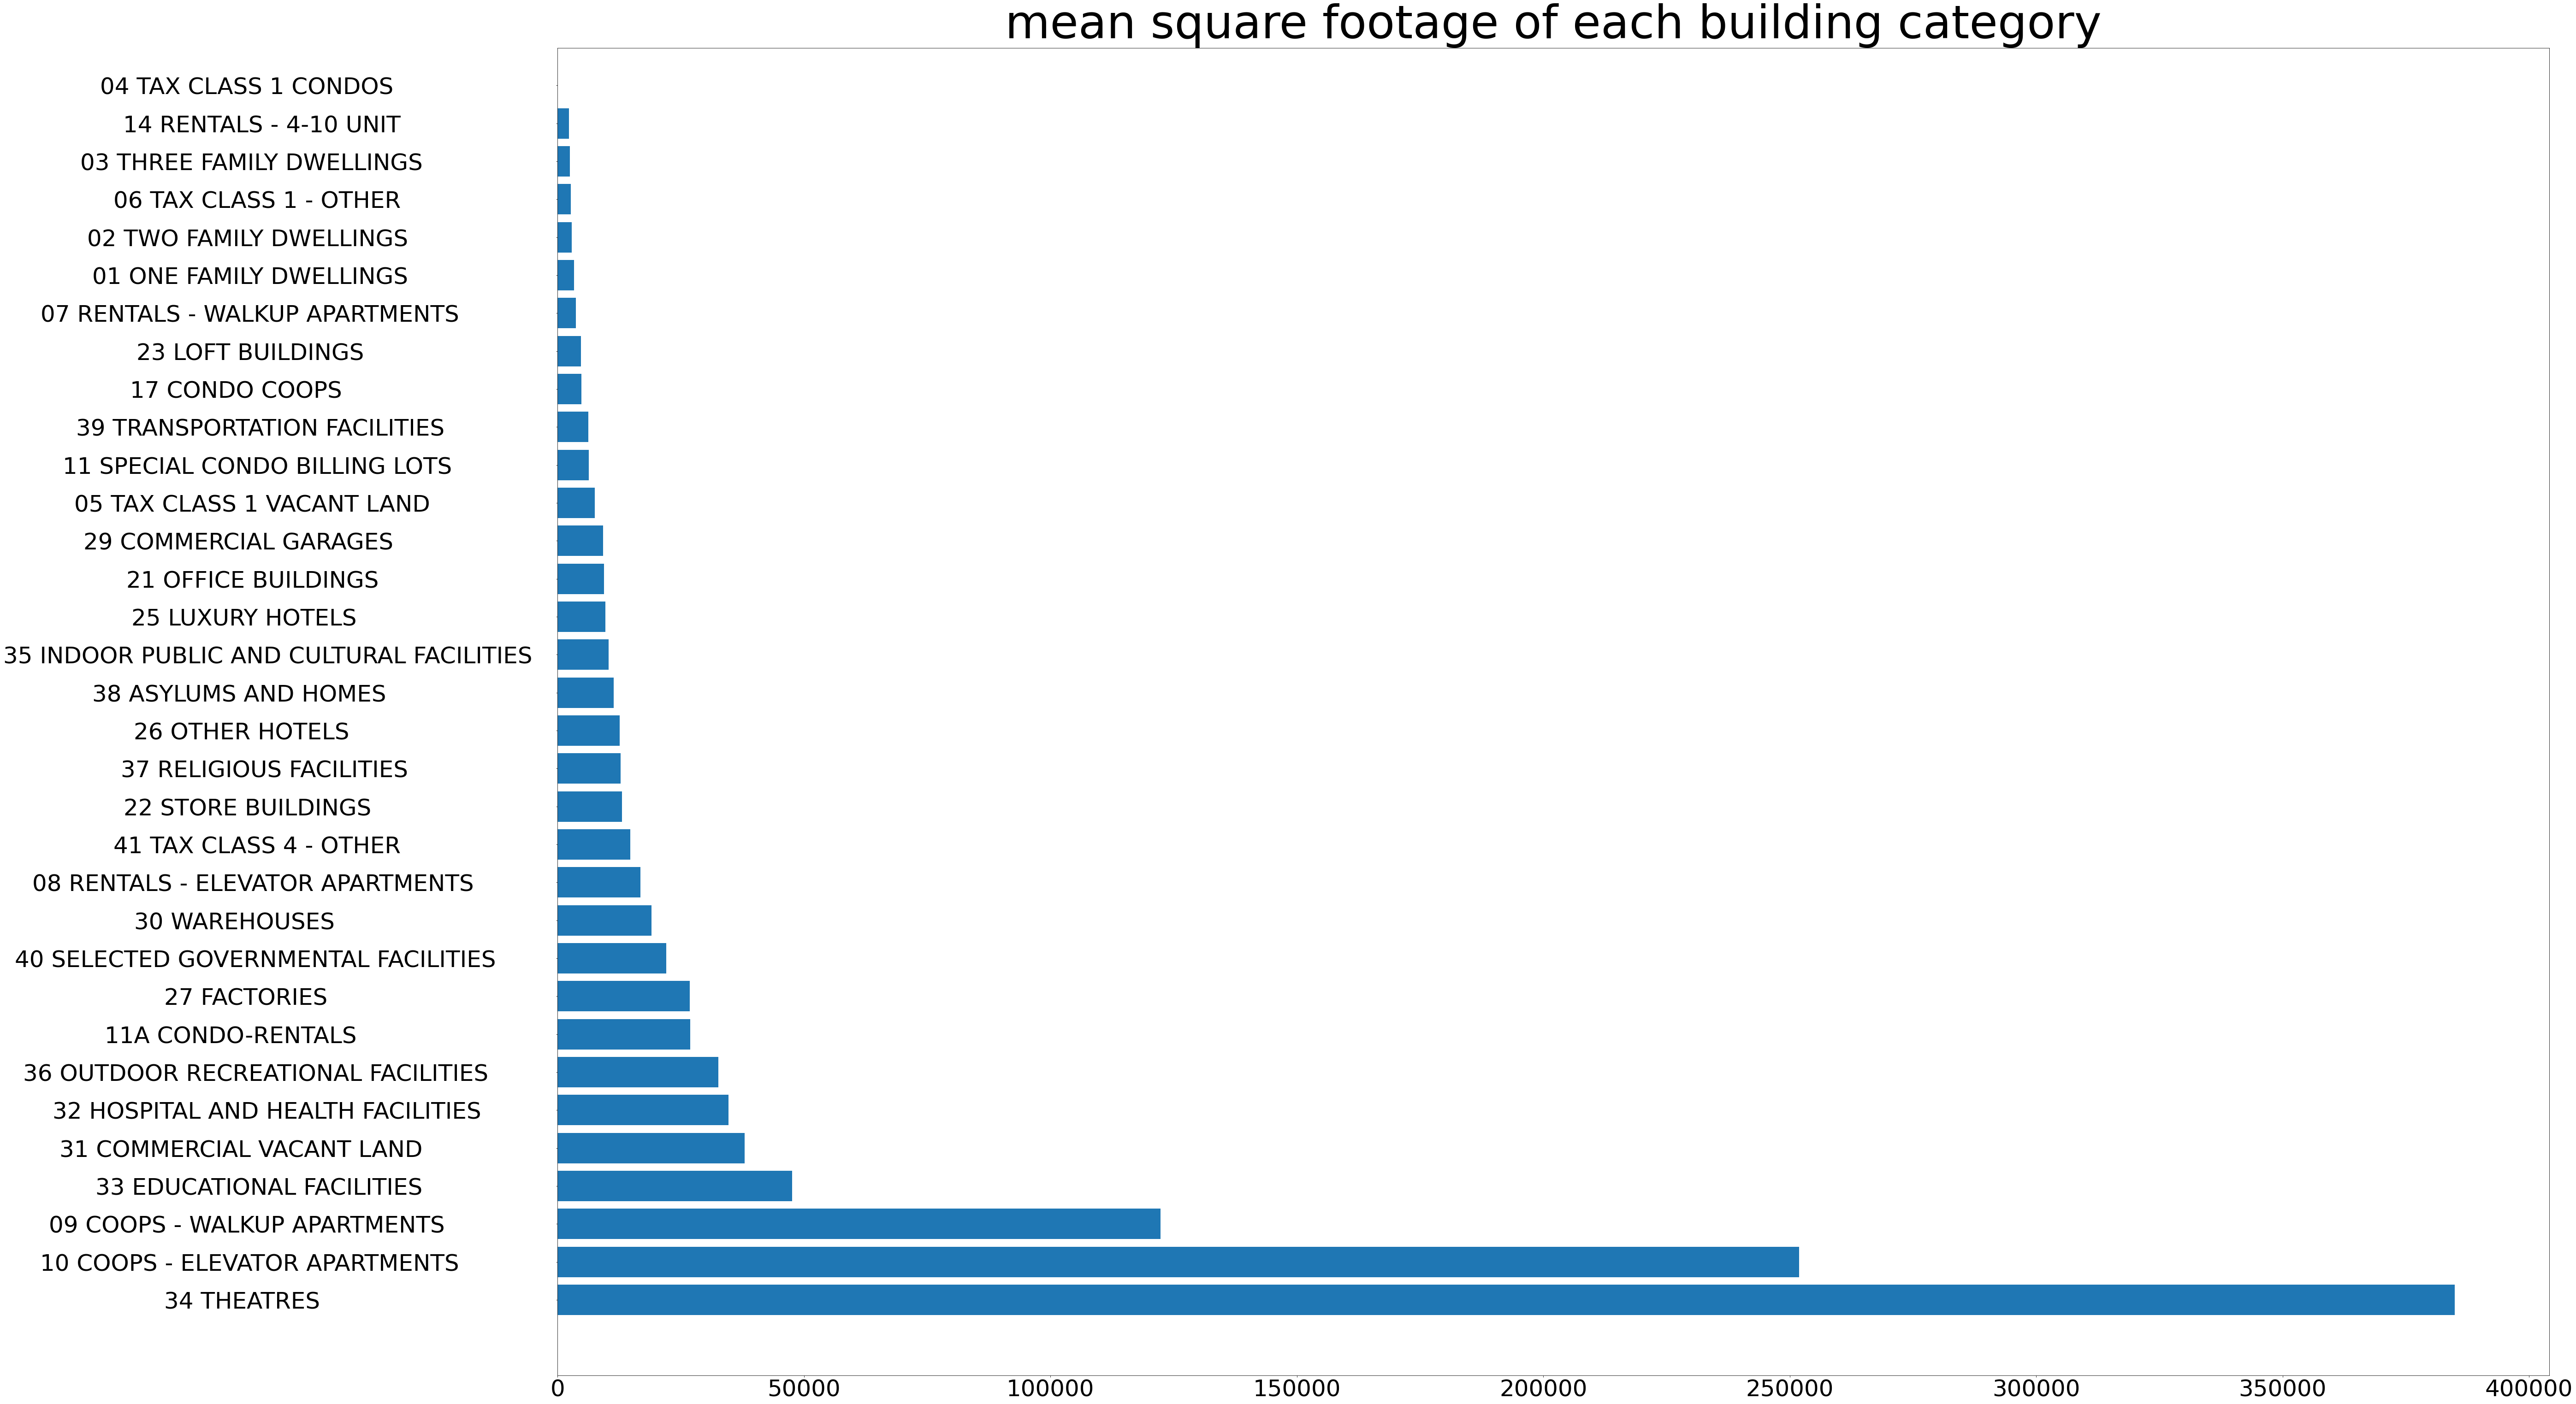

In [101]:
fig = plt.figure()
ax = fig.add_axes([1,1,10,10])

data = nyc_data['LAND SQUARE FEET'].groupby(nyc_data['BUILDING CLASS CATEGORY']).mean().sort_values(ascending = False)

categories = data.index
values = data.values

ax.tick_params(axis = 'both', labelsize = 50)
ax.barh(categories, values)
ax.set_title('mean square footage of each building category', size = 100);

Text(0.5, 1.0, 'how much each tax class constitutes for in square footage')

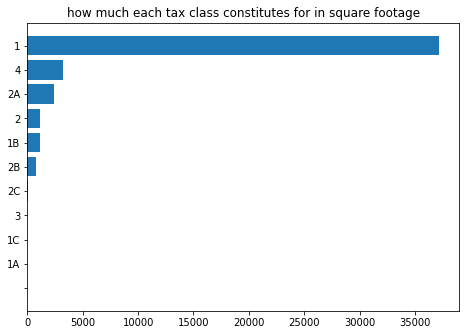

In [102]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])

data = nyc_data['LAND SQUARE FEET'].groupby(nyc_data['TAX CLASS AT PRESENT']).count().sort_values(ascending = True)

categories = data.index
values = data.values

ax.barh(categories, values)
ax.set_title('how much each tax class constitutes for in square footage')

Text(0.5, 1.0, 'how much each tax class constitutes for in square footage')

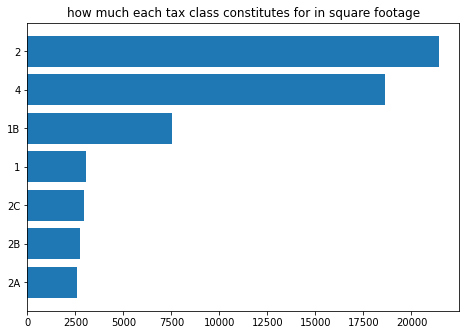

In [103]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])

data = nyc_data['LAND SQUARE FEET'].groupby(nyc_data['TAX CLASS AT PRESENT']).mean().sort_values(ascending = True)

categories = data.index
values = data.values

ax.barh(categories, values)
ax.set_title('how much each tax class constitutes for in square footage')

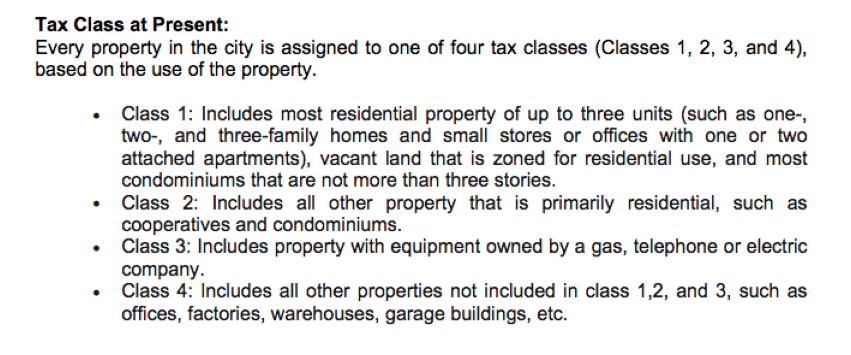

In [104]:
image = Image.open('nyc_tax_class.png')
plt.figure(figsize = (15,15))
plt.imshow(image)
plt.axis('off')
plt.show()

In [105]:
nyc_data.dropna(subset = ['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'SALE PRICE'], inplace = True)

#### to conclude - one, two, three family dwellings and rental apartments are by far the largest chunk of the data, but are all in the bottom 6 positions in the mean square footage. On the other hand, properties with largest square footage have zero or near zero count in the data. This means, that if we tried to impute our values by mean, or median, we would assign large properties small square footage. The nan values will be dropped from those categories

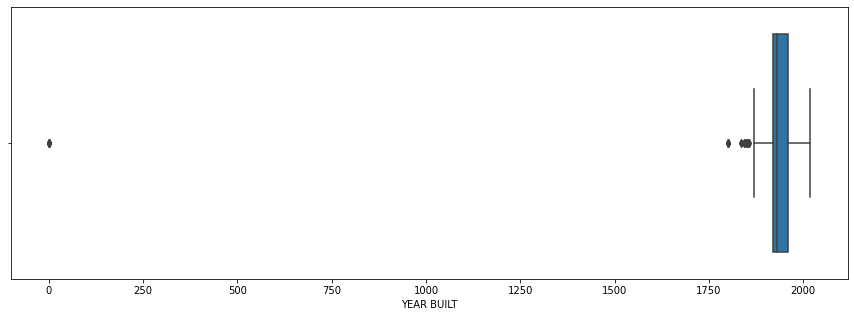

In [106]:
# visualizing YEAR BUILT
plt.figure(figsize = (15,5))
sns.boxplot(nyc_data['YEAR BUILT'])
plt.subplots_adjust(wspace = 0.5)
# data lower than 1950 will be dropped

In [107]:
# YEAR BUILT has 6970 zeros and one value with 1111, so those will be dropped. 
# NaN values in GROSS SQUARE FEET, LAND SQUARE FEET and SALE PRICE will also be dropped, imputing them
# could result in largely incorrect data and model
nyc_data = nyc_data[(nyc_data['YEAR BUILT'] !=0) & (nyc_data['YEAR BUILT'] > 1910)]
nyc_data = nyc_data[nyc_data['ZIP CODE'] != 0]

In [108]:
nyc_data

,BOROUGH,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
3,1,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0
6,1,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0
9,1,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,10009,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0
11,1,08 RENTALS - ELEVATOR APARTMENTS,2B,400,21,D1,10009,10,0,10,3717.0,12350.0,2009,2,D1,10350000.0
22,1,09 COOPS - WALKUP APARTMENTS,2,376,14,C6,10009,24,0,24,4131.0,16776.0,1928,2,C6,11900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,5,02 TWO FAMILY DWELLINGS,1,7349,34,B9,10309,2,0,2,2400.0,2575.0,1998,1,B9,450000.0
84544,5,02 TWO FAMILY DWELLINGS,1,7349,78,B9,10309,2,0,2,2498.0,2377.0,1998,1,B9,550000.0
84545,5,02 TWO FAMILY DWELLINGS,1,7351,60,B2,10309,2,0,2,4000.0,1496.0,1925,1,B2,460000.0
84546,5,22 STORE BUILDINGS,4,7100,28,K6,10309,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0


### exploration

In [109]:
# stripping string names for convenience
nyc_data['BUILDING CLASS CATEGORY'] = nyc_data['BUILDING CLASS CATEGORY'].apply(lambda x: x.strip())

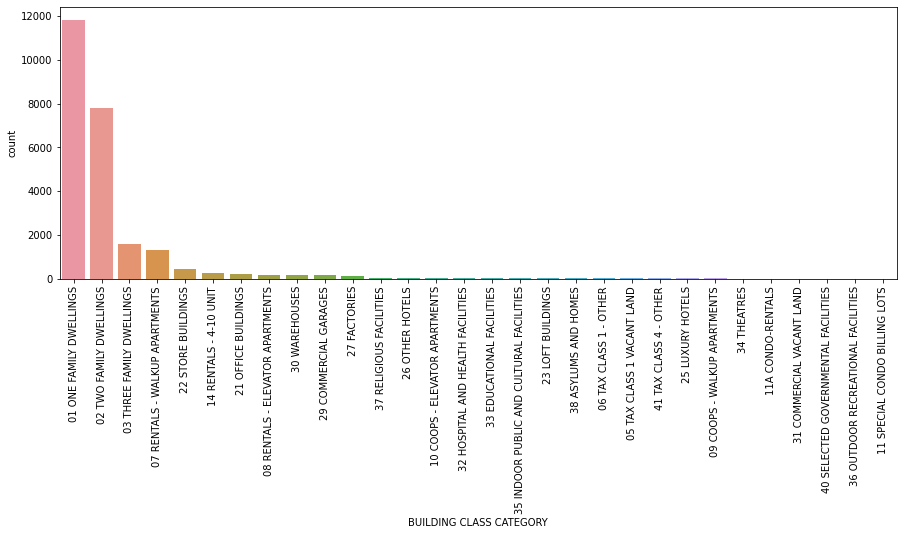

In [110]:
fig = plt.figure(figsize = (15,5))
order = nyc_data['BUILDING CLASS CATEGORY'].value_counts().index
sns.countplot(x = 'BUILDING CLASS CATEGORY', data = nyc_data,
              order = order)
plt.xticks(rotation = 90)
plt.show()

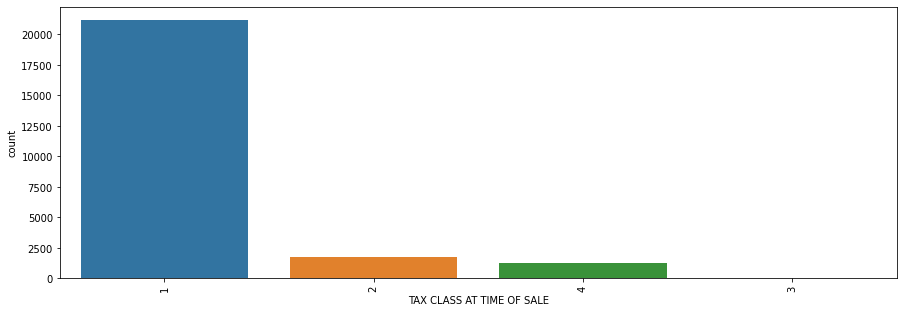

In [111]:
fig = plt.figure(figsize = (15,5))
order = nyc_data['TAX CLASS AT TIME OF SALE'].value_counts().index
sns.countplot(x = 'TAX CLASS AT TIME OF SALE', data = nyc_data,
              order = order)
plt.xticks(rotation = 90)
plt.show()

In [112]:
# For simplicity purpose, we will keep the most numerous categories
categories = nyc_data['BUILDING CLASS CATEGORY'].value_counts().head(10).index.tolist()
nyc_data = nyc_data[nyc_data['BUILDING CLASS CATEGORY'].isin(categories)]

### outliers

In [113]:
nyc_data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,2.388100e+04,2.388100e+04,23881.000000,2.388100e+04
mean,6072.826431,64.869478,11013.788870,2.606800,0.174323,2.780327,3.807244e+03,3.627214e+03,1947.651187,1.408670e+06
std,3789.062239,124.939895,472.431745,13.859265,1.667244,14.123960,2.038285e+04,2.447757e+04,27.948159,1.813907e+07
min,5.000000,1.000000,10001.000000,0.000000,0.000000,0.000000,2.000000e+02,2.050000e+02,1911.000000,1.000000e+00
25%,3281.000000,20.000000,10465.000000,1.000000,0.000000,1.000000,2.000000e+03,1.318000e+03,1925.000000,4.196660e+05
50%,5458.000000,39.000000,11228.000000,1.000000,0.000000,1.000000,2.525000e+03,1.764000e+03,1940.000000,5.990000e+05
75%,8391.000000,66.000000,11379.000000,2.000000,0.000000,2.000000,4.000000e+03,2.480000e+03,1960.000000,8.800000e+05
max,16319.000000,3710.000000,11694.000000,948.000000,126.000000,955.000000,1.865243e+06,1.617206e+06,2017.000000,2.210000e+09


<Figure size 7200x7200 with 0 Axes>

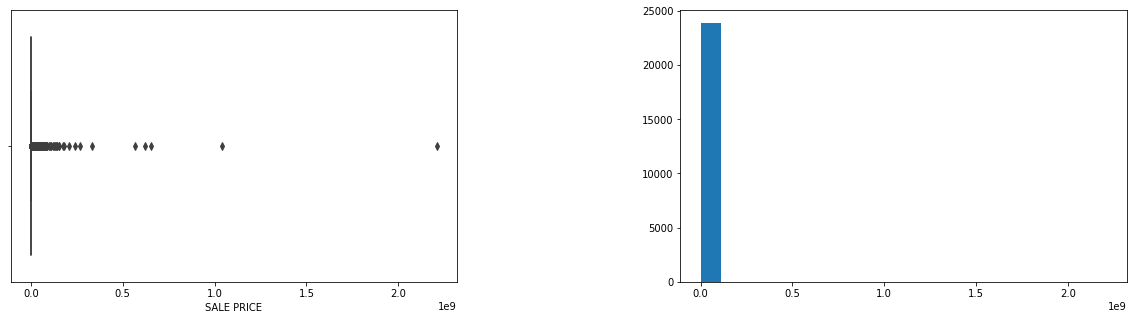

In [114]:
# for now let's remove outliers from just square footage and sale price
plt.figure(figsize = (100,100))
fig, axes = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(nyc_data['SALE PRICE'], ax = axes[0])
axes[1] = plt.hist(nyc_data['SALE PRICE'], bins = 20)
plt.subplots_adjust(wspace = 0.5)

In [115]:
# setting limits 
lower_limit = np.quantile(nyc_data['SALE PRICE'], 0.05)
upper_limit = np.quantile(nyc_data['SALE PRICE'], 0.95)
nyc_data = nyc_data[nyc_data['SALE PRICE'] > lower_limit]
nyc_data = nyc_data[nyc_data['SALE PRICE'] < upper_limit]

<Figure size 7200x7200 with 0 Axes>

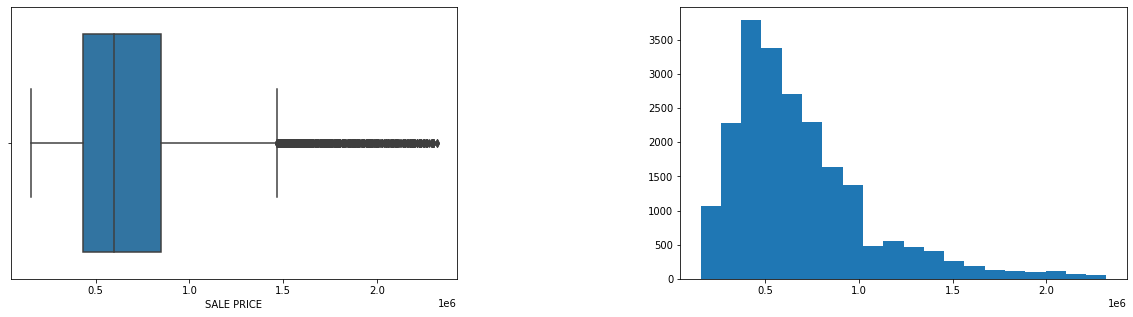

In [116]:
plt.figure(figsize = (100,100))
fig, axes = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(nyc_data['SALE PRICE'], ax = axes[0])
axes[1] = plt.hist(nyc_data['SALE PRICE'], bins = 20)
plt.subplots_adjust(wspace = 0.5)

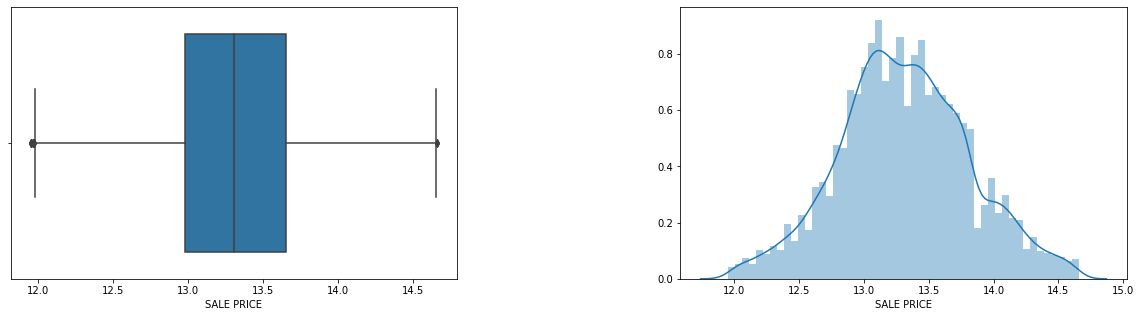

In [117]:
fig, axes = plt.subplots(1,2, figsize = (20,5))
sns.boxplot(np.log(nyc_data['SALE PRICE']), ax = axes[0])
sns.distplot(np.log(nyc_data['SALE PRICE']), ax = axes[1])
plt.subplots_adjust(wspace = 0.5)

### correlation

Text(0.5, 1.0, 'correlation to SALE PRICE')

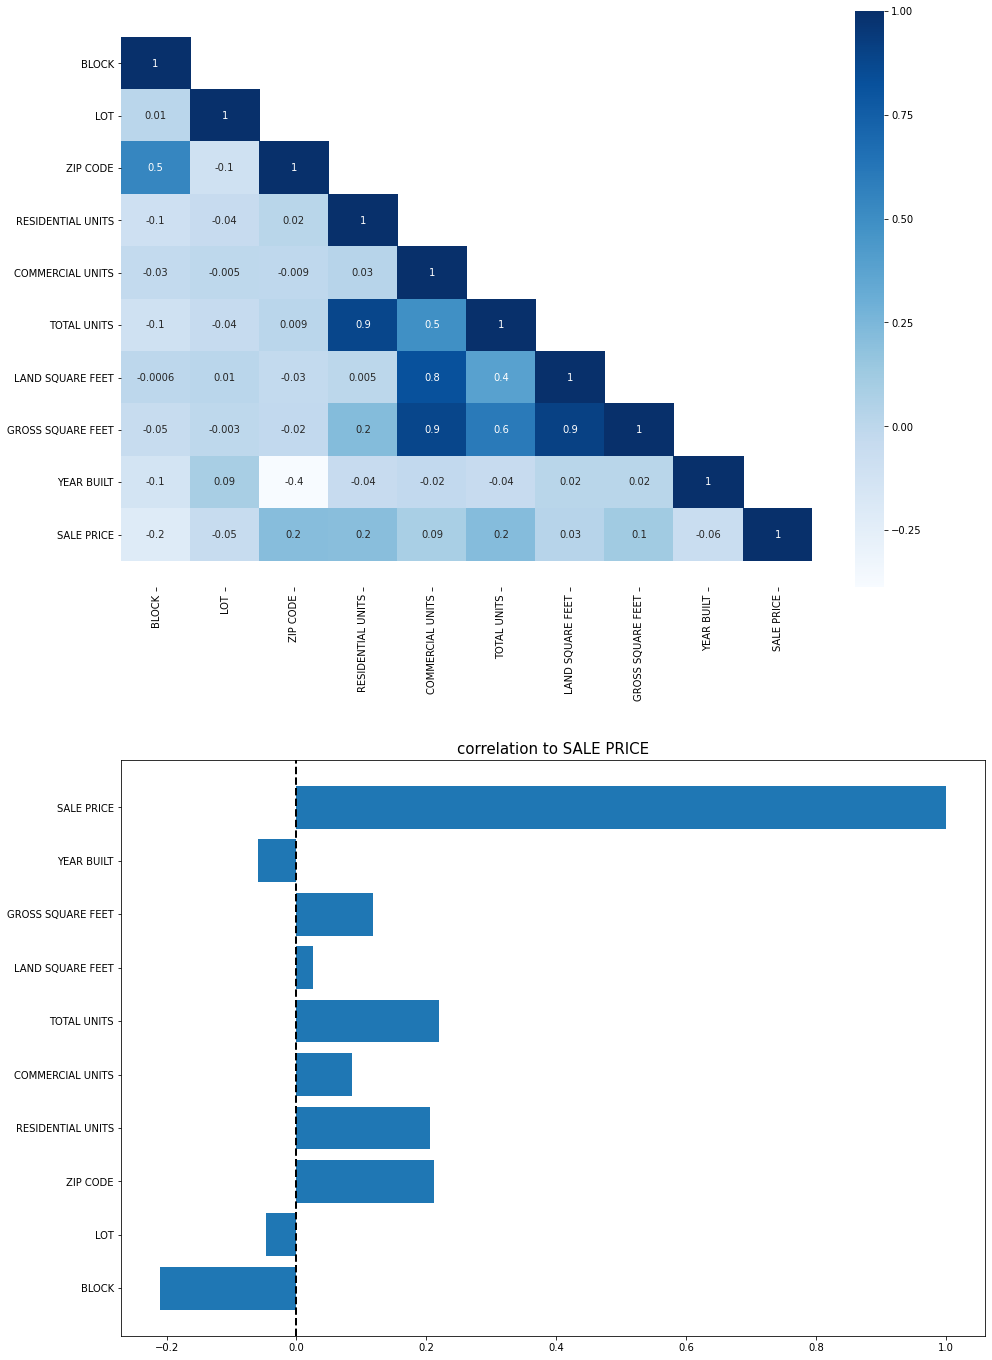

In [118]:
fig = plt.figure()
ax1 = fig.add_axes([0, 2.6, 2, 2])
ax2 = fig.add_axes([0, 0, 2, 2])

correlation = nyc_data.corr()
sns.heatmap(correlation, ax = ax1, annot = True, mask = np.triu(correlation, 1), fmt = '.1g', cmap = "Blues")
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom+0.5, top-0.5)

categories = correlation['SALE PRICE'].index
values = correlation['SALE PRICE'].values
ax2.barh(categories, values)
ax2.axvline(x=0, c = 'k', linewidth = 2, linestyle = '--' )
ax2.set_title('correlation to SALE PRICE', size = 15)

In [119]:
# highly correlated variables are RESIDENTIAL UNITS, COMMERCIAL UNITS and TOTAL UNITS, and 
# LAND SQUARE FEET with GROSS SQUARE FEET, let's drop the unnecessary ones
# nyc_data.drop(['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET'], axis = 1, inplace = True)

<AxesSubplot:xlabel='TOTAL UNITS'>

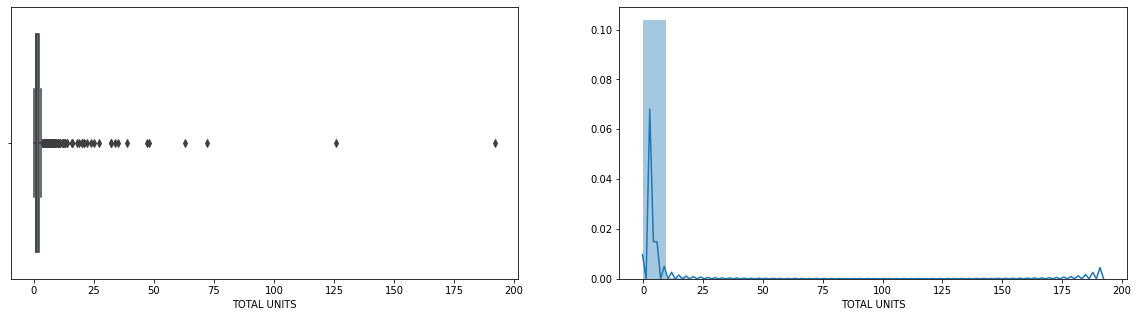

In [120]:
fig, axes = plt.subplots(1,2,figsize = (20, 5))
sns.distplot(nyc_data['TOTAL UNITS'], bins = 20, ax = axes[1])
sns.boxplot(nyc_data['TOTAL UNITS'], ax = axes[0])

In [121]:
# removing outliers
nyc_data = nyc_data[nyc_data['TOTAL UNITS']!=0]
nyc_data = nyc_data[nyc_data['TOTAL UNITS'] < 2000]

#### Tax classes variables comparison

In [122]:
print('TAX CLASS AT PRESENT unique values      {}'.format(np.unique(nyc_data['TAX CLASS AT PRESENT'])))
print('TAX CLASS AT TIME OF SALE unique values {}'.format(np.unique(nyc_data['TAX CLASS AT TIME OF SALE'])))

TAX CLASS AT PRESENT unique values      ['1' '2' '2A' '2B' '4']
TAX CLASS AT TIME OF SALE unique values [1 2 4]


In [123]:
def split(string):
    result = re.findall('\d', string)
    return result[0]

subclass_dropped = nyc_data['TAX CLASS AT PRESENT'].astype(str).apply(lambda x: split(x))
counted_true = subclass_dropped[subclass_dropped == nyc_data['TAX CLASS AT TIME OF SALE'].astype(str)].count()
rate = counted_true/nyc_data.shape[0]
rate = np.round(rate, 4) * 100
print('how much TAX CLASS AT PRESENT is the same as TAX CLASS AT TIME OF SALE? {}%'\
      .format(rate))

how much TAX CLASS AT PRESENT is the same as TAX CLASS AT TIME OF SALE? 100.0%


In [124]:
# if we ignore the subcategories of 'B' and 'A', we have essentially the same variables. We will drop 
# TAX CLASS AT PRESENT
nyc_data.drop(['TAX CLASS AT PRESENT'], axis = 1, inplace = True)

#### Building class variables

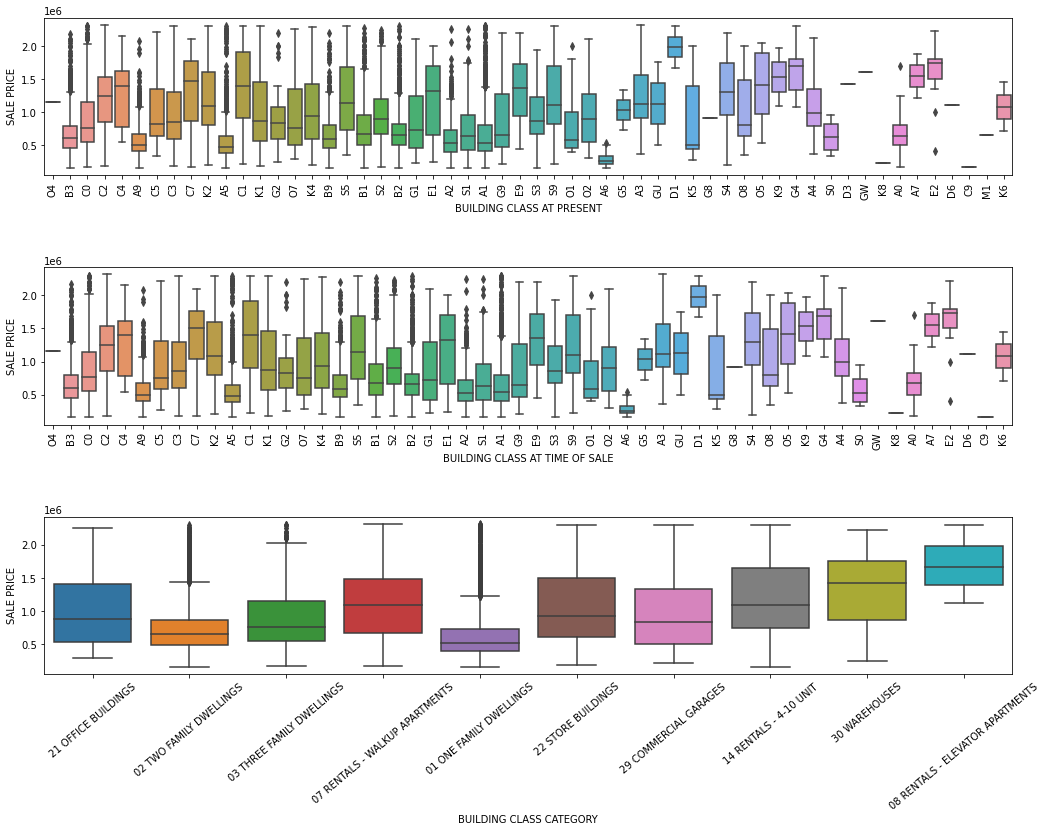

In [129]:
fig, axes = plt.subplots(3,1, figsize = (15,10))
sns.boxplot(x = 'BUILDING CLASS AT PRESENT', y = 'SALE PRICE', data = nyc_data, ax = axes[0])
sns.boxplot(x = 'BUILDING CLASS AT TIME OF SALE', y = 'SALE PRICE', data = nyc_data, ax = axes[1])
sns.boxplot(x = 'BUILDING CLASS CATEGORY', y = 'SALE PRICE', data = nyc_data, ax = axes[2])
plt.tight_layout(h_pad = 5)
axes[0].tick_params(axis = 'x',rotation = 90)
axes[1].tick_params(axis = 'x',rotation = 90)
axes[2].tick_params(axis = 'x',rotation = 40)

In [130]:
#The BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE feel redundant when we already have 
#BUILDING CLASS CATEGORY
nyc_data.drop(['BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS AT PRESENT'], 
              axis = 1, inplace = True)

### Skewed data

In [132]:
# before we work on our model, we want to remove any skewedness from our data
numerical_data = nyc_data.select_dtypes(include = np.number)
numerical_columns = numerical_data.columns

skews = nyc_data[numerical_columns].skew().apply(lambda x: x if x > 0.75 else np.nan).dropna()
nyc_data[skews.index] = np.log1p(nyc_data[skews.index])

### type selector transformer

In [409]:
# We area creating a class that we will be able to plug into our models and select columns by type
# It is necessary, because we want to perform different operation for numerical and categorical data
class SelectColumnsByTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, type_to_select= 'numeric'):
        self.type_to_select = type_to_select
    
    # even if nothing to fit, this method must return self
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        if self.type_to_select == 'numeric':
            return X.select_dtypes(include=np.number)
        else:
            return X.select_dtypes(exclude=np.number)

### Modeling

In [174]:
X = nyc_data.drop(['SALE PRICE'], axis = 1)
y = nyc_data['SALE PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [176]:
num_steps = [
    ('select_num_columns', SelectColumnsByTypeTransformer(type_to_select = 'numeric')),
    ('scaler', StandardScaler())
]

cat_steps = [
    ('select_cat_columns', SelectColumnsByTypeTransformer(type_to_select = 'categorical')),
    ('one_hot_encoder', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
]

cat_pipeline = Pipeline(steps = cat_steps)
num_pipeline = Pipeline(steps = num_steps)

transformer_list = [
    ('categorical_pipeline', cat_pipeline),
    ('numerical_pipeline', num_pipeline)
]

combined_pipeline = FeatureUnion(transformer_list = transformer_list)


#### linear regression

In [177]:
linear_regression_pipeline = Pipeline(steps = [
    ('combined_pipeline', combined_pipeline),
    ('lin_reg', LinearRegression())
])

In [178]:
linear_regression_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('combined_pipeline',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_cat_columns',
                                                                  SelectColumnsByTypeTransformer(type_to_select='categorical')),
                                                                 ('one_hot_encoder',
                                                                  OneHotEncoder(categorical_features=None,
                                                                                categories=None,
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                             

In [179]:
linear_regression_pipeline.score(X_test, y_test)

0.46032033184977694

In [180]:
preds = linear_regression_pipeline.predict(X_test)
print('r2 score: {}'.format(linear_regression_pipeline.score(X_test, y_test)))
print('root mean squared error: {}'.format(np.sqrt(mean_squared_error(y_test, preds))))

r2 score: 0.46032033184977694
root mean squared error: 0.37093415372855354


#### Lasso regression

In [198]:
lasso_pipeline = Pipeline(steps = [
    ('combined_pipeline', combined_pipeline),
    ('lasso_reg', Lasso(alpha = 0.0001))
])

In [199]:
lasso_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('combined_pipeline',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_cat_columns',
                                                                  SelectColumnsByTypeTransformer(type_to_select='categorical')),
                                                                 ('one_hot_encoder',
                                                                  OneHotEncoder(categorical_features=None,
                                                                                categories=None,
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                             

In [200]:
preds = lasso_pipeline.predict(X_test)
print('r2 score: {}'.format(lasso_pipeline.score(X_test, y_test)))
print('root mean squared error: {}'.format(np.sqrt(mean_squared_error(y_test, preds))))

r2 score: 0.46016676557129965
root mean squared error: 0.37098692477892936


#### Ridge regression

In [201]:
ridge_pipeline = Pipeline(steps = [
    ('combined_pipeline', combined_pipeline),
    ('lasso_reg', Ridge(alpha = 0.0001))
])

In [202]:
ridge_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('combined_pipeline',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_cat_columns',
                                                                  SelectColumnsByTypeTransformer(type_to_select='categorical')),
                                                                 ('one_hot_encoder',
                                                                  OneHotEncoder(categorical_features=None,
                                                                                categories=None,
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                             

In [203]:
preds = ridge_pipeline.predict(X_test)
print('r2 score: {}'.format(ridge_pipeline.score(X_test, y_test)))
print('root mean squared error: {}'.format(np.sqrt(mean_squared_error(y_test, preds))))

r2 score: 0.4602515471750518
root mean squared error: 0.37095779161383824


#### decision tree regressor

In [204]:
decision_tree_regression_pipeline = Pipeline(steps = [
    ('combined_pipeline', combined_pipeline),
    ('decision_tree_regression', DecisionTreeRegressor())
])

In [205]:
decision_tree_regression_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('combined_pipeline',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_cat_columns',
                                                                  SelectColumnsByTypeTransformer(type_to_select='categorical')),
                                                                 ('one_hot_encoder',
                                                                  OneHotEncoder(categorical_features=None,
                                                                                categories=None,
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                             

In [206]:
preds = decision_tree_regression_pipeline.predict(X_test)
print('r2 score: {}'.format(decision_tree_regression_pipeline.score(X_test, y_test)))
print('root mean squared error: {}'.format(np.sqrt(mean_squared_error(y_test, preds))))

r2 score: 0.25824078798448724
root mean squared error: 0.4348708213768823


#### random forest regressor

In [207]:
random_forest_regression_pipeline = Pipeline(steps = [
    ('combined_pipeline', combined_pipeline),
    ('random_forest_tree_regression', RandomForestRegressor())
])

In [208]:
random_forest_regression_pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('combined_pipeline',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_cat_columns',
                                                                  SelectColumnsByTypeTransformer(type_to_select='categorical')),
                                                                 ('one_hot_encoder',
                                                                  OneHotEncoder(categorical_features=None,
                                                                                categories=None,
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                             

In [209]:
preds = random_forest_regression_pipeline.predict(X_test)
print('r2 score: {}'.format(random_forest_regression_pipeline.score(X_test, y_test)))
print('root mean squared error: {}'.format(np.sqrt(mean_squared_error(y_test, preds))))

r2 score: 0.5476689222718563
root mean squared error: 0.33959165384780815


### Optimizing our best model

In [396]:
num_steps = [
    ('select_num_columns', SelectColumnsByTypeTransformer(type_to_select = 'numeric')),
    ('scaler', StandardScaler())
]

cat_steps = [
    ('select_cat_columns', SelectColumnsByTypeTransformer(type_to_select = 'categorical')),
    ('one_hot_encoder', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
]

cat_pipeline = Pipeline(steps = cat_steps)
num_pipeline = Pipeline(steps = num_steps)

transformer_list = [
    ('categorical_pipeline', cat_pipeline),
    ('numerical_pipeline', num_pipeline)
]

combined_pipeline = FeatureUnion(transformer_list = transformer_list)

In [390]:
random_forest_regression_pipeline = Pipeline(steps = [
    ('combined_pipeline', combined_pipeline),
    ('random_forest_tree_regression', RandomForestRegressor())
])

In [391]:
combined_pipeline
random_forest_regression_pipeline

Pipeline(memory=None,
         steps=[('combined_pipeline',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('select_cat_columns',
                                                                  SelectColumnsByTypeTransformer(type_to_select='categorical')),
                                                                 ('one_hot_encoder',
                                                                  OneHotEncoder(categorical_features=None,
                                                                                categories=None,
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                             

In [412]:
param_grid = {
    'random_forest_tree_regression__n_estimators' : [10, 50, 100],
    'random_forest_tree_regression__max_features' : ['log2', 'sqrt'],
    'random_forest_tree_regression__max_depth' : [None, 50,100],
    'random_forest_tree_regression__bootstrap' : [True, False],
    'random_forest_tree_regression__min_samples_split' : [2,3,4]
}

grid_search = GridSearchCV(random_forest_regression_pipeline, param_grid, cv = 5)

In [408]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('combined_pipeline',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('categorical_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('select_cat_columns',
                                                                                         SelectColumnsByTypeTransformer(type_to_select='categorical')),
                                                                                        ('one_hot_encoder',
                                                                                         OneHotEncoder(categorical_features=None,
                                                                                     

In [410]:
grid_search.best_params_

{'random_forest_tree_regression__bootstrap': True,
 'random_forest_tree_regression__max_depth': 100,
 'random_forest_tree_regression__max_features': 'sqrt',
 'random_forest_tree_regression__min_samples_split': 4,
 'random_forest_tree_regression__n_estimators': 100}

In [411]:
preds = grid_search.predict(X_test)
print('r2 score: {}'.format(grid_search.score(X_test, y_test)))
print('root mean squared error: {}'.format(np.sqrt(mean_squared_error(y_test, preds))))
print('best parameters for random forest regression: {}'.format(grid_search.best_params_))

r2 score: 0.6026599656211613
root mean squared error: 0.31828044522939836
best parameters for random forest regression: {'random_forest_tree_regression__bootstrap': True, 'random_forest_tree_regression__max_depth': 100, 'random_forest_tree_regression__max_features': 'sqrt', 'random_forest_tree_regression__min_samples_split': 4, 'random_forest_tree_regression__n_estimators': 100}


# Thank you